In [1]:
%%capture
import numpy as np
from tqdm import tqdm

from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import (Dense, Conv2D, LeakyReLU, Dropout, BatchNormalization, Input, Reshape, Flatten,
                          Conv2DTranspose, MaxPooling2D, UpSampling2D)

from material.data import mnist_data
from utils import show_plot


def Generator(latent_dim):
    model = Sequential(name="generator")
    model.add(Input(shape=(latent_dim,)))
    model.add(Dense(128 * 7 * 7, activation=LeakyReLU(alpha=0.2)))
    model.add(Reshape((7, 7, 128)))

    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), activation=LeakyReLU(alpha=0.2), padding='same'))
    # upsample to 14x14

    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), activation=LeakyReLU(alpha=0.2), padding='same'))
    # upsample to 28x28

    model.add(Conv2D(1, (7, 7), activation='sigmoid', padding='same'))

    return model


def Discriminator(in_shape=(28, 28, 1)):
    model = Sequential(name="discriminator")
    model.add(Input(shape=in_shape))
    model.add(Conv2D(64, (3, 3), strides=(2, 2), activation=LeakyReLU(alpha=0.2), padding='same'))
    model.add(Dropout(0.4))

    model.add(Conv2D(64, (3, 3), strides=(2, 2), activation=LeakyReLU(alpha=0.2), padding='same'))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    # compile model
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
    return model


def GAN(latent_dim):
    G = Generator(latent_dim)
    D = Discriminator()

    # connect them
    model = Sequential()
    model.add(Input(shape=(latent_dim,)))
    model.add(G)
    model.add(D)

    model.layers[1].trainable = False
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    

    return G, D, model


def generate_dcm_batch(batch_size, latent_dim, generator, images):
    """
    generate training data for discriminator

    :param generator:
    :param images:
    :param batch_size:
    :param latent_dim:
    :return:
    """

    # select real samples
    def generate_real_data(images, n_samples):
        """

        :param n_samples: batch_size
        :return:
        """

        # choose random instances
        ix = np.random.randint(0, images.shape[0], n_samples)
        X = images[ix]

        # generate 'real' class labels (1)
        y = np.ones((n_samples, 1))
        return X, y

    # use the generator to generate n fake examples, with class labels
    def generate_fake_data(generator: Model, latent_dim, n_samples):
        """

        :param n_samples: batch_size
        :return:
        """

        # generate points in latent space
        x_input = np.random.randn(n_samples, latent_dim)
        X = generator.predict(x_input)

        y = np.zeros((n_samples, 1))
        return X, y

    x_real, y_real = generate_real_data(images, batch_size // 2)
    x_fake, y_fake = generate_fake_data(generator, latent_dim, batch_size // 2)

    # create training set for the discriminator
    x = np.concatenate([x_real, x_fake], axis=0)
    y = np.concatenate([y_real, y_fake], axis=0)

    return x, y


def generate_gan_batch(batch_size, latent_dim):
    # here is a little bit different than Ivans paper.
    # we did not use the same fake image in task batch:

    x = np.random.randn(batch_size, latent_dim)  # latent space sample
    y = np.ones((batch_size, 1))  # all true

    return x, y


In [2]:
x_train, _, _, _ = mnist_data(as_img=True)

latent_dim = 100
G, D, model = GAN(latent_dim)

(60000, 28, 28, 1)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(10000, 28, 28, 1)
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [3]:
G.summary()
D.summary()
model.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 1)         6273      
Total params: 1,164,289
Trainable params: 1,164,289
Non-trainable params: 0
_________________________________________________________________
Model: "discriminator"
_________________________________________________________________
Layer (type)            

100%|██████████| 234/234 [00:31<00:00,  7.51it/s]


>1/20, disc_loss=0.804, gan_loss=0.560
origin:


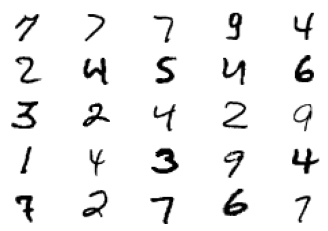

make:


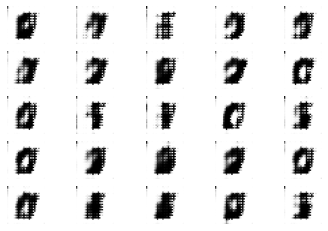

100%|██████████| 234/234 [00:30<00:00,  7.78it/s]


>2/20, disc_loss=0.660, gan_loss=0.718
origin:


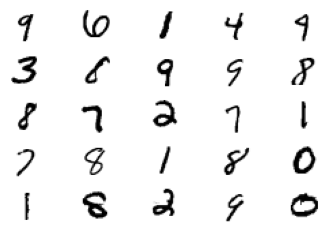

make:


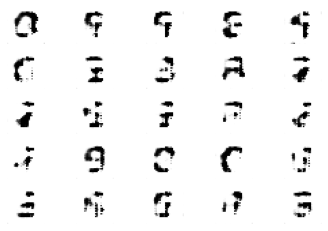

100%|██████████| 234/234 [00:31<00:00,  7.52it/s]


>3/20, disc_loss=0.685, gan_loss=0.721
origin:


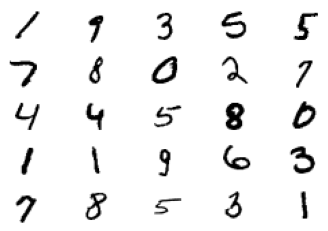

make:


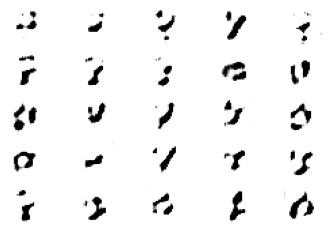

100%|██████████| 234/234 [00:30<00:00,  7.73it/s]


>4/20, disc_loss=0.658, gan_loss=0.739
origin:


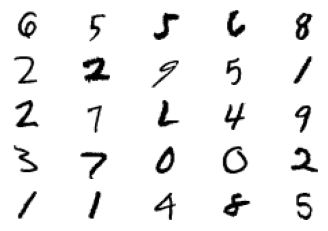

make:


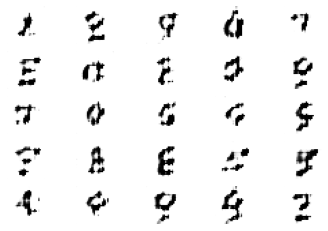

 53%|█████▎    | 124/234 [00:15<00:14,  7.85it/s]


KeyboardInterrupt: 

In [4]:
# train model
n_epochs = 20
batch_size = 256
n_batch = int(len(x_train) / batch_size)
for i in range(n_epochs):
    for j in tqdm(range(n_batch)):
        x_img, y_img = generate_dcm_batch(batch_size, latent_dim, G, x_train)
        d_loss, _ = D.train_on_batch(x_img, y_img)

        x_hid, y_hid = generate_gan_batch(batch_size, latent_dim)
        g_loss = model.train_on_batch(x_hid, y_hid)  # the D is frozen in gan

    # summarize loss on this epoch
    print('>%d/%d, disc_loss=%.3f, gan_loss=%.3f' % (i + 1, n_epochs, d_loss, g_loss))

    # show generation
    print("origin:")
    show_plot(x_img, 5)
    print("make:")
    show_plot(G.predict(x_hid), 5)